#### Aspectos formales de los árboles de decisión
La exposición formal sobre los árboles de decisión se basa en Shalev-Shwartz, S y Ben-David,
S. 2014. Understanding Machine Learning: From Theory to Algorithms. Capítulo 18: Decision
Trees, y Hastie, T; Tibshirani, R y Friedman, J. 2009. The Elements of Statistical Learning:
Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch9: Additive
Models, Trees, and Related Methods. 9.2: Tree-Based Methods.

Los árboles de decisión son métodos con forma funcional 𝑓(𝑥): 𝑋 → 𝑦 que permiten predecir
una clase asociada y con una instancia específica 𝑥 al recorrer desde un nodo principal
hasta una hoja (o nodo terminal). El objetivo de los árboles de decisión es encontrar una
serie de reglas de división del espacio muestral que optimicen la decisión local. En cada
nodo se busca resolver la siguiente función:

$$ \hat f(x) = \sum_{n = 1}^{s} c_mI (X_1, X_2) \in R_m $$

Donde 𝑅 es la región m producto de la partición definido en el espacio de atributos 𝑚
𝑅𝑚 ∋ (𝑋1, 𝑋2) .
𝑐 es el promedio del vector objetivo en la región. El objetivo es dado una partición del 𝑚
espacio de atributos, encontrar un puntaje de corte (denominado s) que asigne una nueva
observación a una de las dos regiones.

$$ R_1(j, s) = \{ X|X_j \leq s\} \hspace*{1em} ó \hspace*{1em} R_2(j, s) = \{ X|X_j \geq s\} $$

Para encontrar el puntaje de corte s en el espacio de atributos, es necesario optimizar por
algún criterio. En este caso trabajaremos con un árbol de regresión donde el vector objetivo
es contínuo.

$$ argmin_{j, s} \left[ argmin_{j, s} \sum_{x_1 \in R} (y_i - C_1)^2 + argmin_{j, s} \sum_{x_1 \in R} (y_i - C_2)^2 \right] $$

Donde $C_1$ y $C_2$ hacen referencia al promedio específico del vector objetivo en el espacio a dividir

$$ \hat c_1 = promedio(y_i|X_i \in R_1(j, s)) y  \hat c_2 = promedio(y_i|X_i \in R_2(j, s))$$ 

El proceso se itera hasta que las particiones realizadas en cada espacio de atributos no
sean informativas. Esto se conoce como pureza de la partición. Para el caso de los árboles
de regresión, el criterio para implementar es el error cuadrático promedio, que cuantifica la
contribución en la reducción de la varianza de determinado atributo. Posteriormente
trabajaremos con árboles de clasificación que implementan otros criterios de optimización.

#### Árboles de Regresión: Analizando los precios del mercado inmobiliario en California

Para ejemplificar cómo funcionan los árboles de decisión, utilizaremos una base de datos
sobre precios de inmuebles en California. La fuente de los datos proviene de Pace, K and
Barry, R. 1997. Sparse Spatial Autoregressions. Statistics and Probability Letters. 33: 291-297.
El objetivo es generar predicciones del precio de los inmuebles en California, dado su
posición geográfica (Longitud y Latitud), cantidad de piezas, el ingreso promedio de la zona,
población, cantidad de casas y el año de la casa. Partamos por preparar nuestro ambiente
de trabajo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import lec7_graphs as afx

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('Datasets/cadata.csv', header = 1).drop(columns = '1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MedianHouseValue  20640 non-null  float64
 1   MedianIncome      20640 non-null  float64
 2   MedianHouseAge    20640 non-null  float64
 3   TotalRooms        20640 non-null  float64
 4   TotalBedrooms     20640 non-null  float64
 5   Population        20640 non-null  float64
 6   Households        20640 non-null  float64
 7   Latitude          20640 non-null  float64
 8   Longitude         20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Como siempre, un primer paso es ver cómo se comportan las variables. Para este ejemplo,
todas las variables son numéricas y punto flotante, por lo que podremos realizar un gráfico
de densidad.

In [3]:
df.sample(2, random_state = 15820)

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude
6637,153500.0,2.5750,39.0,2776.0,840.0,2546.0,773.0,34.16,-118.14
9831,313900.0,3.5147,28.0,3983.0,852.0,1582.0,778.0,36.63,-121.93


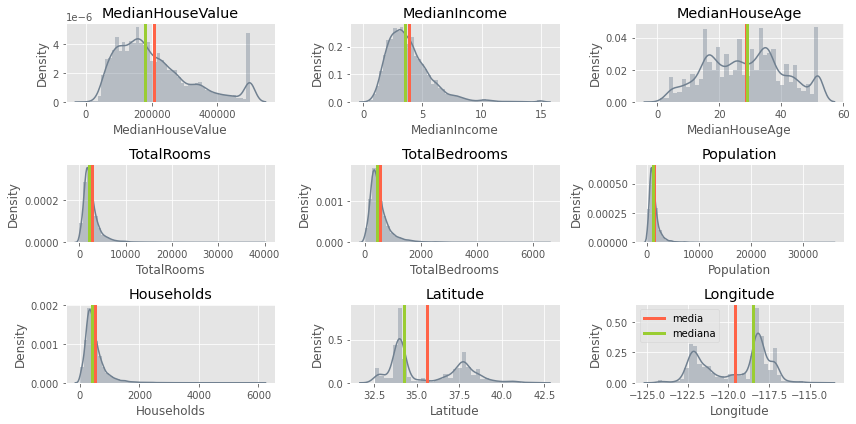

In [4]:
rows, cols = df.shape
cols = np.sqrt(cols)

plt.figure(figsize=(12, 6))
for index, (colname, serie) in enumerate(df.iteritems()):
        plt.subplot(int(cols), int(cols), index + 1)
        sns.distplot(serie, color = 'slategrey')
        plt.axvline(np.mean(serie), color = 'tomato', label = "media", lw=3)
        plt.axvline(np.median(serie), color = 'yellowgreen', label = 'mediana',lw=3)
        plt.title(colname)
plt.tight_layout()
plt.legend()


Mediante la inspección visual de los datos, nos percatamos que hay dos variables
candidatas para transformarlas con logaritmo. La primera es nuestra variable objetivo
MedianHouseValue y la segunda es MedianIncome, la cual representa el ingreso mediano del
sector donde se encuentra la casa.

Observamos que Latitude y Longitude presentan una distribución empírica con dos
cúspides. Cabe destacar que mientras la latitud presenta una cúspide más pronunciada en
los valores bajo la media, la longitud presenta una cúspide más pronunciada en los valores
sobre la media.

Resulta que ambas nos permiten realizar un mapeo sobre cómo se distribuyen los precios
del mercado inmobiliario en California. El gráfico demuestra que hay dos núcleos que
concentran los mayores precios de inmuebles (con colores rojos más pronunciados). Estos
corresponden al Bay Area (que incluyen ciudades como San Francisco, Palo Alto y San
José), y a Los Ángeles.


Text(0.5, 1.0, 'Observaciones registradas')

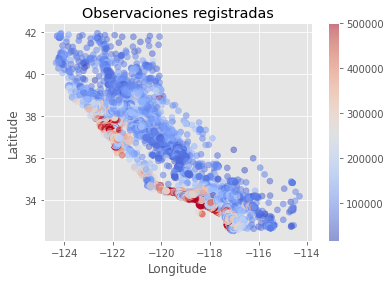

In [5]:
plt.scatter(df['Longitude'], df['Latitude'], c = df['MedianHouseValue'], cmap = 'coolwarm', alpha = .5)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Observaciones registradas')

#### Nuestro primer árbol de regresión
Con nuestros datos inspeccionados, podemos comenzar a preparar nuestro análisis. Para
montar nuestro primer modelo, simplemente incorporaremos todos atributos en el modelo.
Debemos realizar los siguientes pasos:

1. Transformar los atributos MedianHouseValue y MedianIncome con el logaritmo.
2. Eliminar los atributos repetidos en la matriz de atributos.
3. Generar conjuntos de entrenamiento y validación.

In [6]:
# Vamos a trabajar con el logaritmo del vector para reducir no linealidad
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
# Sobreescribimos medianincome a log(medianincome)
df['log_MedianIncome'] = np.log(df['MedianIncome'])
# Definimos nuestro vector objetivo
y = df['log_MedianHouseValue']
# Definimos nuestra matriz de atributos y eliminamos irrelevantes
X = df.drop(columns=['MedianHouseValue', 'log_MedianHouseValue',
'MedianIncome'])
# Generamos muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

Para implementar nuestro árbol de regresión, necesitamos incorporar la clase
DecisionTreeRegressor del módulo tree disponible en la librería sklearn. Como todo
modelo de sklearn, los pasos para ejecutarlo son instanciar, ejecutar y contrastar el modelo
siguiendo métricas. Dado que nuestro vector objetivo es contínuo, implementaremos las
métricas más comunes como el error cuadrático promedio (mean_squared_error), la
mediana del error absoluto (median_absolute_error), y el coeficiente de determinación
(r2_score).

In [7]:
# Implementamos nuestro modelo sin modificar hiperparametros
dec_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [8]:
y_hat = dec_tree.predict(X_test)
y_hat[:5]

array([12.02455077, 12.49874226, 11.97477091, 11.55310725, 10.91508846])

In [9]:
print(f'''Metricas 
Test MSE: {mean_squared_error(y_test, y_hat).round(5)}
Test MAE: {median_absolute_error(y_test, y_hat).round(5)}
Test R2:  {r2_score(y_test, y_hat).round(5)}''')

Metricas 
Test MSE: 0.10949
Test MAE: 0.15864
Test R2:  0.65512


Con nuestro modelo ejecutado, comparamos las métricas. Tanto el error cuadrático
promedio como la mediana del error absoluto sugieren que nuestro modelo erra en
aproximadamente .10 puntos en la escala logarítmica de nuestro vector objetivo. El
coeficiente de determinación sugiere que hay un 67% de variabilidad en nuestro vector
objetivo en la muestra de validación que se explica por los parámetros entrenados en
nuestra muestra de validación. Si bien el desempeño del modelo es relativamente aceptable,
hay márgen substancial para mejoras. Como todo modelo de aprendizaje de máquinas,
cuando queremos mejorar la capacidad predictiva, comenzamos a ajustar los
hiperparámetros.

### Hiperparámetros en los árboles de decisión

Los hiperparámetros a modificar en los árboles de decisión están asociados con las
siguientes preguntas:

- ¿Hasta qué punto puedo dejar crecer un árbol?
- ¿Cuántos datos son suficientes en cada nodo para particionar o declararlo terminal?
- ¿Cuántos atributos son suficientes para que mi árbol pueda capturar de buena manera el fenómeno?

Otro aspecto a considerar y que visitaremos posteriormente, es el hecho que éstos
hiperparámetros son idénticos si estamos hablando de un problema de regresión o
clasificación. Para visualizar las particiones en el espacio, restringiremos el ejercicio a los
atributos Longitud y Latitud, dado que permiten mapear de forma directa la división de áreas
de la región de California.

#### Máximo de profundidad

Ya sabemos que un árbol puede crecer de manera indefinida hasta que todos los nodos
sean puros. En este escenario es más que probable que terminemos con un modelo muy
bien ajustado a los datos de entrenamiento, que falla en poder ser generalizado a nuevas
instancias. Este problema de overfitting se puede solucionar mediante la limitación de qué
tan profundo puede ser un árbol.

En la implementación de sklearn, el hiperparámetro de profundidad de los nodos se
controla con 'max_depth'. Si bien no hay reglas específicas sobre un rango de máxima
profundidad, sabemos que debe partir en 1 dado que ésta es la partición mínima posible. El
rango de término puede ir desde 10 hasta arriba. En la figura generada como
afx.train_test_over_params evaluamos el error cuadrático promedio del modelo en las
muestras de entrenamiento y validación.

Hay un par de comportamientos a destacar:

- En la medida que la profundidad máxima se torna más permisiva, el error cuadrático
  promedio en la muestra de entrenamiento se acerca a cero. Esta es una situación de
  overfitting.
- La curva del modelo en el testing set se estanca cuando la profundidad máxima del
  árbol es aproximadamente igual a 10. Este parece ser un buen hiperparámetro a
  incorporar.


In [10]:
df.sample(5, random_state = 15820)

,MedianHouseValue,MedianIncome,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude,log_MedianHouseValue,log_MedianIncome
6637,153500.0,2.5750,39.0,2776.0,840.0,2546.0,773.0,34.16,-118.14,11.941456,0.945850
9831,313900.0,3.5147,28.0,3983.0,852.0,1582.0,778.0,36.63,-121.93,12.656830,1.256954
5992,154200.0,4.2639,26.0,2744.0,494.0,1411.0,465.0,34.08,-117.71,11.946006,1.450184
7477,121000.0,2.6953,36.0,1337.0,382.0,1769.0,393.0,33.93,-118.21,11.703546,0.991510
4494,109100.0,2.0950,52.0,470.0,115.0,434.0,123.0,34.06,-118.21,11.600020,0.739554


In [11]:
# generamos subconjuntos específicos para el problema de dos atributos
x_tr, x_te, y_tr, y_te = train_test_split(df.loc[:, ['Longitude', 'Latitude']], df['log_MedianHouseValue'], test_size = .33, random_state = 15820)

Text(0, 0.5, 'Error Cuadrático Promedio')

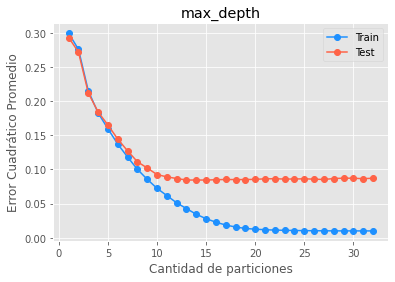

In [12]:
# simulamos el desempeño en el rango del hiperparámetro
afx.train_test_over_params(DecisionTreeRegressor(), 
        {'max_depth': np.linspace(1, 32, 32).astype(int)}, x_tr, x_te, y_tr, y_te)
plt.xlabel('Cantidad de particiones')
plt.ylabel('Error Cuadrático Promedio')

Ahora visualicemos cómo se comporta la superficie de respuesta en la medida que
aumentamos la profundidad del árbol. Cuando restringimos su profundidad a 1, se genera
sólo 1 frontera de decisión, aproximadamente en la latitud 38.

Inmuebles arriba de esta latitud tendrán en promedio valores más bajos que los situados
debajo de la latitud. Cuando la profundidad es evaluada en 10, nos permite recabar
información. No toda observación situada en esta latitud es más cara. Hay un par de rectas
en el cuadrante inferior izquierdo con un color rojo más fuerte, que son las zonas de San
Francisco y Palo Alto, respectivamente.


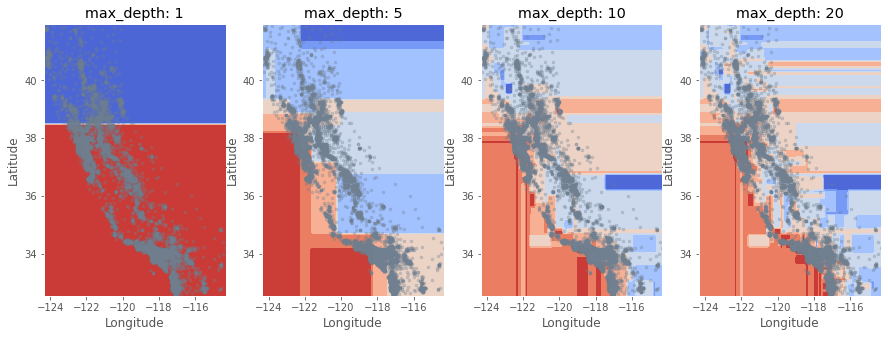

In [13]:
plt.figure(figsize=(15, 5))
# para cada valor predefinido del hiperparámetro
for index, value in enumerate([1, 5, 10, 20]):
        plt.subplot(1, 4, index + 1)
        # Implementamos un modelo con el ajuste específico
        tmp_model = DecisionTreeRegressor(max_depth = value)
        # Visualizamos la superficie de respuesta
        afx.plot_decision_function(tmp_model, df, 'Longitude', 'Latitude', 'log_MedianHouseValue',colorbar = False)
        plt.title("max_depth: {}".format(value))

#### Cantidad de atributos
El hiperparámetro 'max_features' nos permite discriminar con cuántos atributos podemos
alcanzar un buen desempeño del modelo. Recordemos que uno de los principios base de la
modelación es la parsimonía: La capacidad de explicar de mejor manera con la menor
cantidad de atributos posibles. Observamos que el efecto de la cantidad de atributos en la
muestra de entrenamiento no afecta su desempeño, pero sí tiene un rol fundamental en la
muestra de validación. Para este caso, los puntajes en el desempeño se estancan cuando
consideramos entre 3 y 4 atributos.

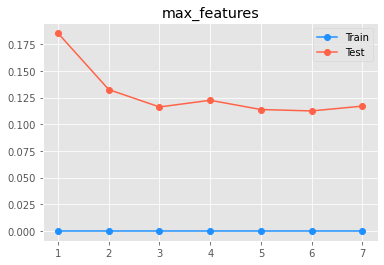

In [14]:
afx.train_test_over_params(DecisionTreeRegressor(), 
        {'max_features':list(range(1, X_train.shape[1]))},X_train, X_test, y_train, y_test)

Uno de los puntos a favor de los modelos de árboles de decisión es que nos permite medir
la importancia relativa de cada atributo en nuestro vector objetivo. Para obtener los puntajes
de importancia relativa de un modelo, pueden acceder a ellos mediante
.feature_importances_ en el objeto instanciado, posterior al fit. De manera alternativa,
puede ocupar la función afx.plot_importance. Se observa que MedianIncome, Longitude y
Latitude son los atributos con una mayor importancia en predecir valores de nuestro vector
objetivo. Podemos inferir que los precios están determinados de forma parcial por la
ubicación y qué tan acaudalado es el sector, cosa que parece razonable.

In [15]:
dec_tree.feature_importances_

array([0.04416244, 0.02277906, 0.02445701, 0.03122879, 0.01900569,
       0.16854975, 0.19475973, 0.49505755])

Text(0, 0.5, 'Atributos')

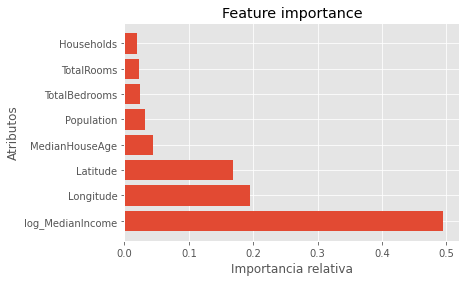

In [32]:
afx.plot_importance(dec_tree, X.columns)
plt.xlabel("Importancia relativa")
plt.ylabel('Atributos')

La importancia de un atributo en el contexto de los árboles se puede entender en la
contribución que este atributo tiene en la reducción de impurezas. A grandes rasgos la
importancia mide el grado de influencia en la decisión de un árbol. Atributos con una mayor
carga relativa significarán que se posicionarán antes en el proceso de decisión. Cargas altas
significan que la división forzada por ese atributo fue más pura. Si bien es tentador asumir
que los atributos con cargas bajas son menos informativos, esto no es evidencia de su
irrelevancia: Puede significar que el modelo no ha evaluado bien los atributos.

### Mínimo de muestras en un nodo particionable

Parte importante de nuestro árbol de decisión recae en los nodos. Mediante el mínimo de
muestras en un nodo, respondemos cuándo podemos considerarlo como un nodo de
decisión (donde podemos particionar) y cuando es un nodo terminal (no podemos
particionar). En la medida que aumentamos la cantidad mínima de observaciones en el
nodo, nuestro árbol se torna menos flexible. En situaciones donde se le pide una parte
substancial de los casos, el modelo puede incurrir en alto sesgo y falta de acople en la
partición de los datos. Esto conlleva a underfitting.

sklearn asume que el hiperparámetro considera el porcentaje específico del número de
muestras. En el gráfico se aprecia que en la medida que nuestro modelo necesita de un
mayor porcentaje de datos para poder considerar un nodo como válido para particionar, el
error cuadrático promedio aumenta. En esta situación, el gráfico nos informa que ambas
curvas tienen un comportamiento similar, y por tanto hay que elegir el hiperparámetro que
disminuya el error en ambas.

Text(0, 0.5, 'Error Cuadrático Promedio')

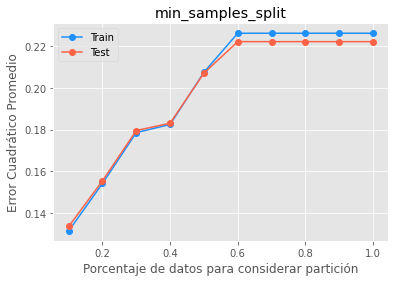

In [17]:
afx.train_test_over_params(DecisionTreeRegressor(),
        {'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint = True)}, X_train, X_test, y_train, y_test)
plt.xlabel('Porcentaje de datos para considerar partición')
plt.ylabel('Error Cuadrático Promedio')

Para aclarar el comportamiento del mínimo de datos para considerar una partición,
visualicemos la superficie de respuesta. En un extremo, cuando tenemos valores bajos, la
superficie de respuesta tiende a ser mucho más consciente del rango de valores. En el
extremo opuesto, cuando ésta se vuelve alta, nuestra capacidad de particionar nodos
disminuye, generando una menor cantidad de divisiones.

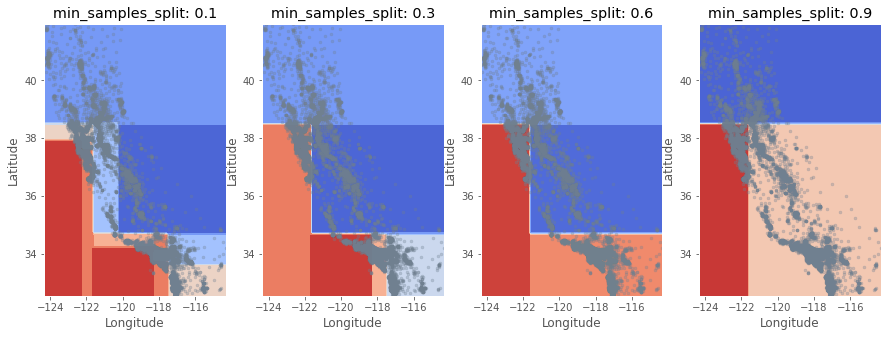

In [18]:
plt.figure(figsize = (15, 5))
for index, value in enumerate([0.1, 0.3, 0.6, 0.9]):
        plt.subplot(1, 4, index + 1)
        tmp_model = DecisionTreeRegressor(min_samples_split = value)
        afx.plot_decision_function(tmp_model, df, 'Longitude', 'Latitude','log_MedianHouseValue',colorbar = False)
        plt.title("min_samples_split: {}".format(value))


Mínimo de muestras en un nodo terminal
Mediante el mínimo de muestras en un nodo terminal, definimos cuándo el proceso de
búsqueda termina en un nodo. Cuando los valores son bajos, significa que el modelo
necesitará un menor porcentaje de los datos para poder crecer, aumentando su rango de
acción.

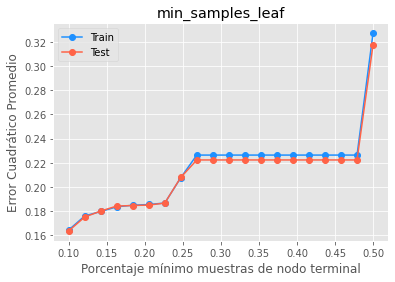

In [19]:
afx.train_test_over_params(DecisionTreeRegressor(),
        {'min_samples_leaf': np.linspace(0.1, 0.5,20, endpoint=True)},X_train, X_test, y_train, y_test)
plt.xlabel('Porcentaje mínimo muestras de nodo terminal')
plt.ylabel('Error Cuadrático Promedio');

De manera similar a min_samples_split, en la medida que aumentamos el valor de éste
hiperparámetro lo tornamos más estricto, conllevando a underfitting.

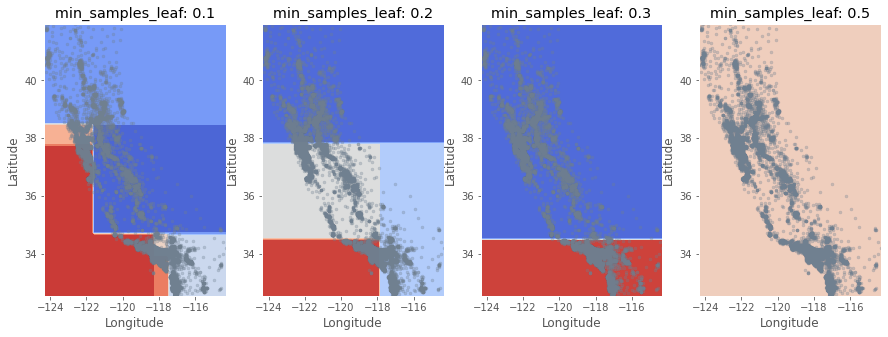

In [20]:
plt.figure(figsize=(15, 5))
for index, value in enumerate([0.1,.20, .3, 0.5]):
        plt.subplot(1, 4, index + 1)
        tmp_model = DecisionTreeRegressor(min_samples_leaf=value)
        afx.plot_decision_function(tmp_model, df, 'Longitude', 'Latitude','log_MedianHouseValue',colorbar=False)
        plt.title("min_samples_leaf: {}".format(value))


### Árboles de Clasificación: Identificando la probabilidad de votar en un Plebiscito

Para exponer sobre los árboles de clasificación vamos a trabajar con una encuesta sobre
votación en un Plebiscito a favor o en contra de una ley. Los atributos a considerar son la
región del encuestado, la población de la ciudad donde vive el encuestado, el sexo del
encuestado, la edad, el nivel educacional, su ingreso, si apoya o no al régimen y su votación
en el Plebiscito.

En los casos que nuestro vector objetivo sea categórico, el procedimiento de partición se
mantiene igual y sólo hay que cambiar el criterio de optimización de particiones. En los
árboles de regresión implementábamos una medida basada en el error cuadrático promedio
en la partición, lo cual no es válido en los casos de clasificación.

$$ Entropia(o Desviacion) =  - \sum_{K=1}^K \hspace*{1em} \hat P_mk log \hat P_mk $$

$$ Gini =  - \sum_{K=1}\hat P_mk log \hat P_mk = \sum_{K=1}^K\hat P_mk(1 - \hat P_mk)$$

$$Error de clasificacion = \dfrac{1}{N_m} \sum_{i \in R_m} I(y_i \neq k(m)) = 1 - \hat P_mk(m)$$

Tanto la entropía como el índice de Gini son más sensibles a los cambios en la probabilidad
de clases en el nodo que la tasa de clasificaciones erróneas. Es por este punto que se
prefiere implementar cualquiera de las dos por sobre la tasa de clasificaciones erróneas.
Resulta que la implementación en sklearn incluye estas dos, ignorando la tasa de
clasificaciones erróneas.

Entre estas dos candidatas, el índice de Gini es preferible dado que presenta una mayor
interpretabilidad que la Entropía. Hastie et al. (2009) sugieren que existen dos
interpretaciones. Más que estar fijándose en la clasificación de observaciones en la clase
mayoritaria (como lo realiza la tasa de error de clasificación), podemos fijarnos en la
clasificación en una clase específica con probabilidad.

$$ \hat P_mk $$

Otra forma de entender el índice de Gini es la razón entre clases. Cuando éste está cercano
a .5, significa que existe una equiprobabilidad entre todas las clases de ocurrir en el nodo.
Este sería un nodo impuro.

Grus (2012) sugiere que nuestro objetivo es encontrar atributos que entreguen mayores
niveles de información sobre lo que nuestro árbol debería predecir. Para obtener esta
medición sobre qué tanta información se obtiene mediante la entropía. Para la ciencia de
datos, la entropía tiene que ver con el grado de incertidumbre en los datos. Si tenemos un
conjunto de datos S donde cada observación se etiqueta con un número C de clases. Si
todos los datos pertenecen a alguna de las clases, no existe incertidumbre, lo que conlleva a
una entropía baja. Viceversa cuando las clases están igualmente repartidas. Buscamos que
la entropía sea lo más alta posible, situación que se logra cuando ésta es cercana a .5.

![graph](fotos/graph.jpg)

#### Implementando un árbol de clasificación
De similar manera, la implementación de un árbol de clasificación se realiza mediante la
incorporación de la clase sklearn.tree.DecisionTreeClasifier. Como se señaló
anteriormente, los hiperparámetros a evaluar en el ajuste del modelo son exactamente los
mismos que en sklearn.tree.DecisionTreeRegression. Lo único que varía es el criterio
de partición. Mientras que en el caso del árbol de regresión se evalúa mediante la reducción
del error cuadrático, en los árboles de clasificación implementamos alguna de las métricas
mencionadas anteriormente.

Comencemos por incorporar la base de datos voting.csv y solicitar una observación al
azar.



In [21]:
# Importamos la base de datos
df = pd.read_csv('Datasets/voting.csv').drop(columns='Unnamed: 0')
df.sample(5, random_state = 15820)

,region,population,sex,age,education,income,statusquo,vote
769,C,175000,F,44.0,S,7500.0,-1.15622,U
1480,S,25000,F,31.0,P,7500.0,1.50986,Y
1523,S,125000,F,40.0,S,35000.0,0.43786,Y
471,C,250000,F,25.0,S,35000.0,-0.65599,N
2193,SA,250000,M,65.0,P,2500.0,1.54947,Y


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      2700 non-null   object 
 1   population  2700 non-null   int64  
 2   sex         2700 non-null   object 
 3   age         2699 non-null   float64
 4   education   2689 non-null   object 
 5   income      2602 non-null   float64
 6   statusquo   2683 non-null   float64
 7   vote        2532 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 168.9+ KB


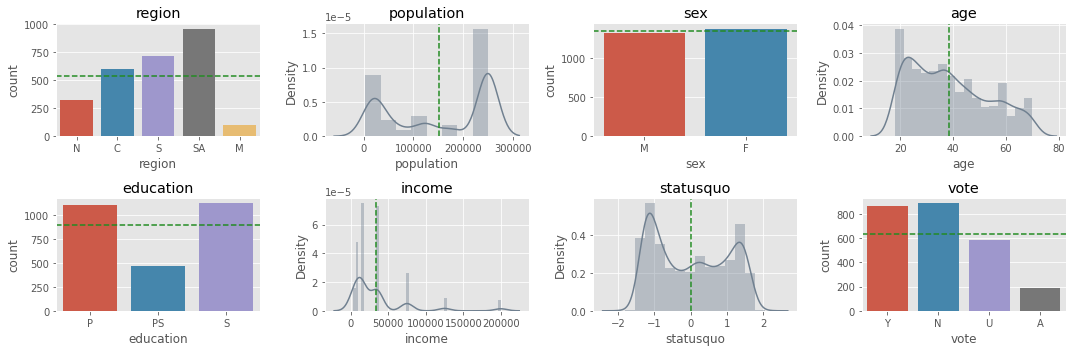

In [23]:
plt.figure(figsize=(15, 5))
rows = 2
cols = df.shape[1] // rows
for index, (colnames, serie) in enumerate(df.iteritems()):
        plt.subplot(rows, cols, index + 1)
        if serie.dtype == 'object':
                sns.countplot(serie.dropna())
                plt.axhline(serie.value_counts().mean(), color = 'forestgreen', linestyle = '--')
                plt.title(colnames)
        else:
                sns.distplot(serie.dropna(), color = 'slategrey')
                plt.axvline(serie.mean(), color='forestgreen', linestyle = '--')
                plt.title(colnames)
plt.tight_layout()

Se observa que en promedio los individuos en la muestra provienen de la región 'SA', el rango
entre hombres y mujeres es relativamente similar. La edad de éstos se sitúa en promedio en
los 40, con una mayor representación de individuos jóvenes. El nivel educacional varía
sustancialmente entre Primario y Secundario. El statusquo indica que el apoyo al régimen
está polarizado entre aquellos que no lo aprueban (con valores negativos), y aquellos que sí.

Posterior a importar la base de datos, generamos una serie de variables por cada categoría
de region, sex, education y nuestro vector objetivo: vote. Para ello implementaremos la
función pd.get_dummies. Para evitar problemas de multicolinealidad en los modelos,
eliminaremos las variables originales.

In [24]:
# Vamos a binarizar cada variable categórica, ignorando la primera categoría de referencia
# Región del país
# Nivel educacional del encuestado
# Sexo del encuestado
# Intención de voto
# Botamos las variables originales
df = pd.concat([df, pd.get_dummies(df['region'], drop_first = True, prefix = 'region')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['education'], drop_first = True, prefix ='ed')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['sex'], drop_first = True, prefix = 'sex')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['vote'], drop_first = False, prefix = 'vote')], axis = 1)
df = df.drop(columns=['region', 'sex', 'education', 'vote'])
df.sample(5, random_state = 15820)

,population,age,income,statusquo,region_M,region_N,region_S,region_SA,ed_PS,ed_S,sex_M,vote_A,vote_N,vote_U,vote_Y
769,175000,44.0,7500.0,-1.15622,0,0,0,0,0,1,0,0,0,1,0
1480,25000,31.0,7500.0,1.50986,0,0,1,0,0,0,0,0,0,0,1
1523,125000,40.0,35000.0,0.43786,0,0,1,0,0,1,0,0,0,0,1
471,250000,25.0,35000.0,-0.65599,0,0,0,0,0,1,0,0,1,0,0
2193,250000,65.0,2500.0,1.54947,0,0,0,1,0,0,1,0,0,0,1


Para efectos prácticos del ejercicio, nuestro objetivo es realizar un árbol de clasificacion que
modele las chances que un individuo vaya a votar No. Lo que necesitamos es generar los
conjuntos de entrenamiento y validación para posteriormente entrenar nuestro modelo,
definiendo la matriz de atributos y el vector objetivo.

In [25]:
# Nos aseguramos de limpiar los datos perdidos
# generamos las muestras definiendo la matriz de atributos
# y el vector objetivo
# definimos el tamaño de la muestra a dejar como validación
# por ultimo la semilla pseudoaleatoria
df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'population':'sex_M'],df['vote_N'],test_size=.33, random_state = 15820)

ara este modelo, implementaremos una búsqueda de grilla con los cuatro hiperparámetros
anteriormente explicados. El número de modelos estimables es:

$$ 10 x 32 x 11 x 5 x 2 = 352.000 $$

Por lo que puede ser computacionalmente demandante. El tiempo de ejecución fue de 4
minutos y 30 segundos.

In [26]:
# importamos la clase GridSearchCV
# evaluamos 10 escenarios
# implementando 2 criterios departición
# con una profundidad de ramas hasta 32
# evaluando 10 escenarios
# evaluando todos los atributos en la matriz
# Con 5 validaciones cruzadas
# Ocupando todos los núcleos del computador
dec_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),{'min_samples_split':np.linspace(0.1, 1.0, 10),
                                                        'criterion': ['gini', 'entropy'], 'max_depth': np.linspace(1, 32, 32).astype(int),
                                                        'min_samples_leaf':np.linspace(0.1, 0.5, 10), 'max_features':list(range(1,X_train.shape[1]))}, 
                                                        cv = 5, n_jobs = -1).fit(X_train, y_train)

Al solicitar la mejor combinación de hiperparámetros, GridSearchCV nos informa que el
máximo de profundidad necesaria de los nodos es de 11, implementando un criterio de
partición basado en el índice de entropía, con un máximo de 6 atributos informativos, y con
una norma para definir los nodos como terminales o particionables relativamente baja.

In [27]:
dec_tree_grid_cv.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'max_features': 8,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

El desempeño en la muestra de entrenamiento es 81%, lo que indica que el modelo clasificó
correctamente aproximadamente el 83% de las observaciones.

In [28]:
dec_tree_grid_cv.best_score_

0.8195965417867435

El hiperparámetro max_features nos indica en este caso que el atributo statusquo
concentra la mayor importancia relativa, seguida de income y age. Se supone que el modelo
informa sobre 5 características, pero sólo 3 presentan importancia susbtancialmente
distinta de cero.

In [29]:
dec_tree_grid_cv.best_estimator_.feature_importances_

array([0.        , 0.00624135, 0.        , 0.97912804, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01463061])

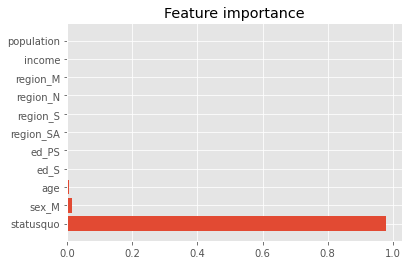

In [30]:
colnames = df.loc[:, 'population':'sex_M'].columns
afx.plot_importance(dec_tree_grid_cv.best_estimator_, colnames)

Evaluando el desempeño de un árbol de clasificación
Realicemos la evaluación del modelo en el held-out, para revisar el desempeño en datos que
no han sido entrenados previamente. Si importamos el método classification_report
para extraer las métricas de evaluación en modelos de clasificación, obtendremos lo
siguiente:

In [31]:
print(classification_report(y_test, dec_tree_grid_cv.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       575
           1       0.81      0.65      0.72       280

    accuracy                           0.84       855
   macro avg       0.83      0.79      0.80       855
weighted avg       0.83      0.84      0.83       855



A grandes rasgos observamos que el modelo disminuyó su capacidad predictiva en 1%. Si
bien esto no es un problema substancial, hay que optar por un desempeño igual o mejor al
del training set. El detalle indica que el modelo tiene un mejor desempeño en clasificar las
observaciones etiquetadas como 0 en comparación a aquellas identificadas como 1.

#### Aspectos adicionales

A continuación se señalan algunos aspectos adicionales a considerar al momento de
implementar árboles de clasificación.

##### Atributos categóricos con k>2

Por defecto, cuando trabajamos con un atributo con k>2 categorías no ordenadas, existen
$2^{𝑘−1}− 1$ posibles divisores que permitan generar subespacios. Este proceso tiene un costo computacional prohibitivo cuando k es muy grande.

La exposición previa de los métodos de árbol se realizó en consideración a que los atributos
son binarios o continuos. Resulta que con los atributos categóricos k > 2 la división no es
directa, por lo que se sugiere binarizar cada categoría. Esta estrategia la implementamos en
el caso del árbol de clasificación.

#### Valores perdidos en los atributos

Para atributos categóricos, podemos generar una categoría nueva para señalar los casos
perdidos en ese atributo. Estos se conocen como predictores subrogados. Por defecto
CART ignora los valores perdidos para medir la ganancia de una división. Para el caso
cuando asignamos observaciones perdidas a uno de los dos lados de la división, CART
implementa subrogados. Estos calculan a qué nivel otra serie de divisores candidatos
producen resultados similares. Posteriormente la observación perdida se clasifica
implementando el subrogado que más se parezca a la división original.

##### Divisiones en la combinación lineal de parámetros
Podemos superar el criterio de división de la forma $𝑋_𝑗 \leq 𝑠$ a uno que permita realizar

divisiones en la combinación lineal de parámetros de la forma $\sum \beta_j X_j \leq \beta_j$
En este escenario, los pesos $\beta_j$ y divisores s se optimizan en función de criterio relevante. 
El trueque en este caso es entre un modelo con un mejor desempeño a riesgo de hacerlo
menos interpretable.

##### Inestabilidad de los árboles
Otro de los problemas frecuentes es la alta varianza existente en los modelos de árboles.
Dado que la optimización de las divisiones depende fuertemente de los datos de
entrenamiento, la modificación parcial de una observación puede conllevar a pérdidas
sustanciales en la similitud del modelo. Esto se debe a que el proceso es estrictamente
jerárquico, donde los errores en nodos superiores se propagan por las ramas.

##### Falta de suavidad en la función
Este es un problema común en los árboles de regresión, donde el vector objetivo tiene una
mejor caracterización en su superficie de respuesta mediante la combinación lineal de
parámetros. Al implementar divisiones en los atributos, omitimos de forma deliberada parte
de la varianza de los atributos, conllevando a una interpretación secuencial y anidada por
sobre la interpretación de la forma funcional lineal.

##### CART no es la única solución
Un aspecto a considerar es que la exposición sobre los árboles presentada corresponde a
un marco analítico llamado CART (Classification And Regression Tree), ideado por Breiman
et al. (1984). Ésta solución no es la única, pero es la que tiene un mayor consenso como
dominante. Existen variantes como el ID3 y el Cubist (4.5/5.0) que tienen implementaciones
separadas (Ver Quinlan, 1986, 1993). Lamentablemente no componen parte de la suite base
de sklearn.

#### Referencias
- Murphy, K. 2012. Machine Learning. A Probabilistic Perspective. Cambridge: MA.
  Massachusetts Institute of Technology Press.
- Breiman, L.; Friedman, J.H.; Olshen, R.A.; and Stone, C.I. 1984. Classification and
  regression trees. Belmont, California: Wadsworth Press.
- Hastie, T; Tibshirani, R, Friedman, J.H. 2009. The Elements of Statistical Learning.
  Data Mining, Inference and Prediction. New York City: NY. Springer.
- Shalev-Shwartz, S y Ben-David, S. 2014. Understanding Machine Learning: From
  Theory to Algorithms. Capítulo 18: Decision Trees.
- Grus, J. 2014. Data Science from Scratch. O'Reilly.